# SVG-VAE

In [1]:
import pyarrow.parquet as pq
import svg_utils
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.utils.data import Dataset, DataLoader
from model import VAEModel
from config import ImageVAEConfig

## Prepare dataset

In [2]:
data_train = pq.read_table('data_train.parquet')
data_train = data_train.to_pandas()

data_test = pq.read_table('data_test.parquet')
data_test = data_test.to_pandas()

data_train.head()

,uni,width,vwidth,sfd,id,binary_fp
0,97,649,1000,"SplineSet\n637 0 m 1,0,-1\n 595 0 l 1,1,-1\n 5...",1,12127215344058962203\n
1,98,560,1000,"SplineSet\n535 284 m 0,0,1\n 535 166 535 166 4...",2,12127215344058962203\n
2,99,712,1000,"SplineSet\n693 125 m 1,0,1\n 686 116 686 116 6...",3,12127215344058962203\n
3,100,710,1000,"SplineSet\n678 378 m 0,0,1\n 678 221 678 221 5...",4,12127215344058962203\n
4,101,613,1000,"SplineSet\n586 0 m 1,0,-1\n 28 0 l 1,1,-1\n 28...",5,12127215344058962203\n


In [3]:
len(data_train)

1971326

Взглянем на сэмпл.

In [4]:
from random import randint
i = 1358568 # randint(0, 1971326)

In [5]:
assert svg_utils._is_valid_glyph(data_train.loc[i])
path = svg_utils._convert_to_path(data_train.loc[i])
assert svg_utils._is_valid_path(path)
data = svg_utils._create_example(path)
data.keys()

dict_keys(['rendered', 'seq_len', 'class', 'binary_fp', 'sequence'])

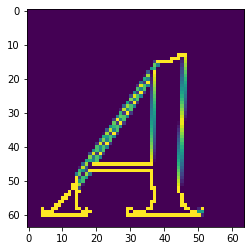

In [6]:
plt.imshow(np.array(data['rendered']).reshape(64, 64))

Подготовим даталоадеры.

In [7]:
data_train.loc[0, :]

uni                                                         97
width                                                      649
vwidth                                                    1000
sfd          SplineSet\n637 0 m 1,0,-1\n 595 0 l 1,1,-1\n 5...
id                                                           1
binary_fp                               12127215344058962203\n
Name: 0, dtype: object

In [8]:
class GlyphDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.map_class = {}
        self.cached = self.__getitem__(0)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        idx=0
        try:
            example = np.array(svg_utils._create_example(svg_utils._convert_to_path(self.df.loc[idx, :]))['rendered']
                              , dtype=np.float32)
            
            if not (self.df.loc[idx, "uni"] in self.map_class):
                len_ind = len(self.map_class)
                self.map_class[self.df.loc[idx, "uni"]] = len_ind
            
            
            std_dev = np.std(example)
            mean = np.mean(example)
            example = (example - mean) / std_dev 
            
            return torch.FloatTensor(example.reshape(1, 64, 64)), self.map_class[self.df.loc[idx, "uni"]]
        except Exception as e:
            return self.cached

In [9]:
glyph_train = GlyphDataset(data_train[:1])
glyph_test = GlyphDataset(data_test)

In [10]:
train_loader = DataLoader(glyph_train, batch_size=128)
for X_batch, Y_batch in train_loader:
    print(X_batch)
    print(Y_batch)
    break

tensor([[[[-0.2767, -0.2767, -0.2767,  ..., -0.2767, -0.2767, -0.2767],
          [-0.2767, -0.2767, -0.2767,  ..., -0.2767, -0.2767, -0.2767],
          [-0.2767, -0.2767, -0.2767,  ..., -0.2767, -0.2767, -0.2767],
          ...,
          [-0.2767, -0.2767, -0.2767,  ..., -0.2767, -0.2767, -0.2767],
          [-0.2767, -0.2767, -0.2767,  ..., -0.2767, -0.2767, -0.2767],
          [-0.2767, -0.2767, -0.2767,  ..., -0.2767, -0.2767, -0.2767]]]])
tensor([0])


## Model declaration

In [11]:
%load_ext autoreload
%autoreload 2

In [48]:
config = ImageVAEConfig('cpu')

In [49]:
device = torch.device('cpu')

In [50]:
model = VAEModel(config).to(device)

In [51]:
from torchsummary import summary

summary(model, [(1, 64, 64), (1, 1, 1)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             832
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
 VisualEncoderCell-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 32, 32, 32]          25,632
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
 VisualEncoderCell-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          51,264
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
VisualEncoderCell-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]         102,464
      BatchNorm2d-14           [-1, 64,

## Training

In [52]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4, eps=1e-11)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=4, min_lr=0.000001)

In [53]:
import time
from tqdm.notebook import tqdm


def train_model(model, opt, scheduler, train_loss, 
                val_accuracy, num_epochs, print_every=5):
    cur_max_acc = None
    for epoch in range(num_epochs):
        #print(f'Start epoch {epoch}')
        start_time = time.time()
        model.train()
        epoch_loss = 0
        i = 0
        for X_batch, Y_batch in train_loader:
            logits, losses = model(X_batch.to(device), Y_batch.to(device))
            loss = model.loss(X_batch, logits)[1]#losses['training']
            loss.backward()
            opt.step()
            opt.zero_grad()
            epoch_loss += loss.item()
            if epoch % print_every == 0:
                plt.imshow(X_batch[0][0])
                plt.show()
                plt.imshow(logits.detach().numpy()[0][0])
                plt.show()
                print(f'Epoch {epoch}, Batch {i}, loss {loss.item()}')
            i += 1
        #cur_val_acc, cur_val_loss = get_accuracy(model, val_batch_gen)
        #epoch_loss /= len(train_batch_gen)
        #scheduler.step(cur_val_loss)
        
        #train_loss.append(epoch_loss)
        #val_accuracy.append(cur_val_acc)
        #val_loss.append(cur_val_loss)
        
        #print("Epoch {} of {} took {:.3f}s".format(
        #    epoch + 1, num_epochs, time.time() - start_time))
        #print('  lr =', scheduler._last_lr[0])
        #print("  training loss (in-iteration): \t{:.6f}".format(epoch_loss))
        #print("  validate loss (in-iteration): \t{:.6f}".format(cur_val_loss))
        #print("  validation accuracy: \t\t\t{:.2f} %".format(cur_val_acc * 100))
        #if cur_max_acc is None or cur_val_acc > cur_max_acc:
        #    cur_max_acc = cur_val_acc
        #    torch.save(model.state_dict(), 'models/residual.best4')

In [54]:
train_loss = []
val_accuracy = []
train_model(model, opt, scheduler, train_loss, val_accuracy, 10000, 100)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [96]:
torch.save(model.state_dict(), 'residual.best4')

In [136]:
model.eval()

VAEModel(
  (encoder): VisualEncoderModel(
    (block1): VisualEncoderCell(
      (conv2d): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (instance_norm): CategoricalConditionalBatchNorm(32, num_cats=62, eps=2e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (block2): VisualEncoderCell(
      (conv2d): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (instance_norm): CategoricalConditionalBatchNorm(32, num_cats=62, eps=2e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (block3): VisualEncoderCell(
      (conv2d): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (instance_norm): CategoricalConditionalBatchNorm(64, num_cats=62, eps=2e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (block4): VisualEncoderCell(
      (conv2d): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (in

In [187]:
img = model.decoder(torch.randn(32), torch.Tensor([1]))

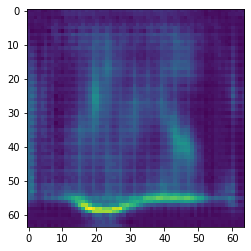

In [188]:
plt.imshow(np.array(img[0][0].detach()))